# Image Prep

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image_folder_path = r"G:\My Drive\trainingImages-lane\original"
os.listdir(image_folder_path)

['1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png',
 '11.png',
 '12.png',
 'backup-unedited-masks.zip',
 '1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 'backup-first-5-masks.zip']

In [10]:
image_file_name = "1.jpg"
mask_file_name = "1.png"

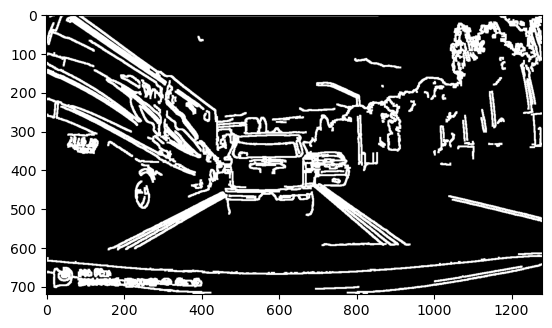

In [42]:
image = cv2.imread(os.path.join(image_folder_path, image_file_name))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),cv2.BORDER_DEFAULT)
low_threshold = 35
high_threshold = 65
edges = cv2.Canny(blur, low_threshold, high_threshold)
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(edges, kernel, iterations=1)
plt.imshow(dilation, cmap='gray')

In [43]:
#cv2.imwrite(os.path.join(reg_image_folder_path, mask_file_name), dilation)

## After saving the rought mask to disk, I edit the mask by hand using an image editor.

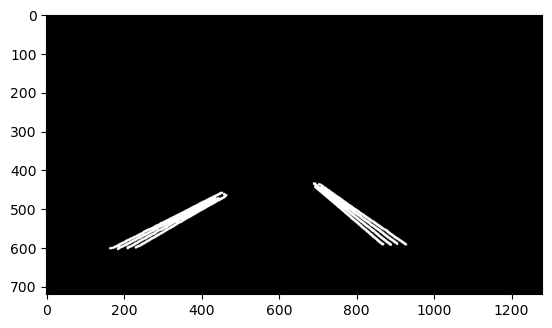

In [48]:
mask_from_file = cv2.imread(os.path.join(image_folder_path, mask_file_name), 0)
plt.imshow(mask_from_file, cmap='gray')

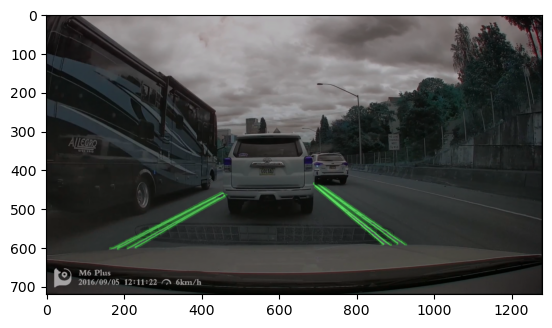

In [47]:
color_mask = np.zeros_like(image)
color_mask[mask_from_file == 255] = (0, 255, 0)
masked_color = cv2.bitwise_and(image, color_mask)
result = cv2.addWeighted(image, 0.7, masked_color, 0.9, 0)
plt.imshow(result)

# Training

In [20]:
import os
import torch
import torchvision
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image

In [21]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # I wasn't sure what to put here, this was an example I found...
])

In [22]:
training_folder = r"G:\My Drive\trainingImages-lane\test-train-1"

In [23]:
# Create the custom dataset class
class LaneDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.masks = []

        for image_name in os.listdir(root_dir):
            if 'mask' in image_name:
                self.masks.append(image_name)
            else:
                self.images.append(image_name)
        print("Length of images list:", len(self.images))
        print("Length of masks list:", len(self.masks))
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(image_path)

        mask_path = os.path.join(self.root_dir, self.masks[idx])
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return (image, mask)

In [24]:
# Load the data
dataset = LaneDataset(root_dir=training_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

Length of images list: 5
Length of masks list: 5


In [25]:
# Verify input shape
for i, (inputs, labels) in enumerate(dataloader):
    print("input shape:", inputs.shape)
    print("label shape:", labels.shape)
    if i == 10:  # break after first iteration
        break

input shape: torch.Size([1, 1, 256, 256])
label shape: torch.Size([1, 1, 256, 256])
input shape: torch.Size([1, 1, 256, 256])
label shape: torch.Size([1, 1, 256, 256])
input shape: torch.Size([1, 1, 256, 256])
label shape: torch.Size([1, 1, 256, 256])
input shape: torch.Size([1, 1, 256, 256])
label shape: torch.Size([1, 1, 256, 256])
input shape: torch.Size([1, 1, 256, 256])
label shape: torch.Size([1, 1, 256, 256])


In [26]:
class SimpleSegmentationModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_filters=32):
        super(SimpleSegmentationModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, num_filters, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters*2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters*4)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(num_filters*4, num_filters*8, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_filters*8)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(num_filters*8, out_channels, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        
        return x

In [27]:
model = SimpleSegmentationModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [28]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, masks = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(dataloader)))

print('Finished Training')

# Save the model
torch.save(model.state_dict(), 'lane_detection_model.pth')

torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
Epoch 1 loss: 0.516
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
Epoch 2 loss: 0.116
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
Epoch 3 loss: 0.171
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
Epoch 4 loss: 0.087
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
Epoch 5 loss: 0.074
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])


# Prediction

In [29]:
import cv2
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from PIL import Image
from torchvision.transforms import ToPILImage, ToTensor

In [30]:
model_path = r"G:\My Drive\lane_detection_model.pth"
image_path = r"G:\My Drive\trainingImages-lane\original\4.jpg"

In [33]:
def predict(model, image):
    # Apply the same data transformations to the image that were used during training
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    image = transform(image).unsqueeze(0)

    # Pass the image through the model to get the predictions
    with torch.no_grad():
        logits = model(image)

    # Apply a sigmoid activation function to the predictions to get a mask
    mask = torch.sigmoid(logits)

    return mask.squeeze().numpy()

In [34]:
# This is the model used to train
class SimpleSegmentationModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_filters=32):
        super(SimpleSegmentationModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, num_filters, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters*2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters*4)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(num_filters*4, num_filters*8, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_filters*8)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(num_filters*8, out_channels, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        
        return x

In [35]:
# Load the saved model
model = SimpleSegmentationModel()
model.load_state_dict(torch.load(model_path))
model.eval()

SimpleSegmentationModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [36]:
# Read an image from file
image = Image.open(image_path)
print(image.size)
image = transform(image)

(1280, 720)


In [37]:
to_pil = ToPILImage()
pil_img = to_pil(image)

In [59]:
mask = predict(model, pil_img)

torch.Size([1, 32, 256, 256])


In [63]:
mask = (mask * 0.5) + 0.5
image = cv2.imread(image_path)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
print(mask.shape)

(720, 1280)


In [40]:
color_mask = np.zeros_like(image)
color_mask[mask == 255] = (0, 255, 0) # green color
masked_color = cv2.bitwise_and(image, color_mask)
cv2.imwrite("test.jpg", masked_color)

True

In [41]:
# Overlay the predicted mask on the original image
print(image.shape)
print(mask.shape)
overlay = cv2.addWeighted(image, 0.9, masked_color, 0.9, 1)
cv2.imwrite("overlay_output.png",overlay)

(720, 1280, 3)
(720, 1280)


True

In [54]:
output_mask_path = r"G:\My Drive\test.jpg"
output_image_path = r"G:\My Drive\overlay_output.png"

In [55]:
output_mask = cv2.imread(output_mask_path)
output_image = cv2.imread(output_image_path)

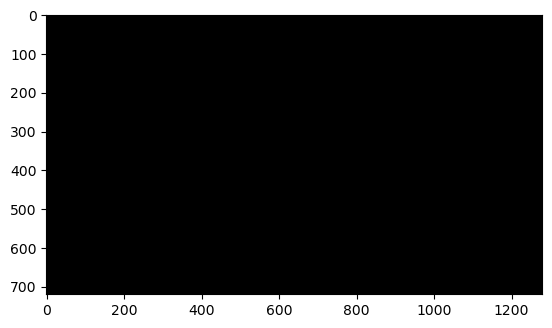

In [56]:
plt.imshow(output_mask)

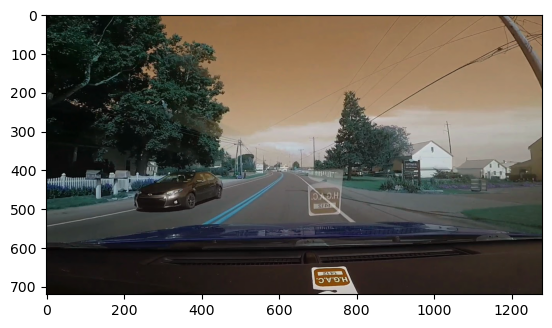

In [58]:
plt.imshow(output_image, cmap='gray')